# Can we guess football results?

**This notebook is complementary to the article published in Medium "Can we guess football results?".**

Author: Alberto Czapka, 2022

_This project is under MIT license._

In [1]:
import pandas as pd
import numpy as np
import glob
import plotly.graph_objs as go
from plotly.offline import plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Downloading dataset

In [2]:
df_full_dataset = pd.DataFrame()

for i in range(2, 22):
    if i < 9:
        year = f'0{i}0{i + 1}'
    elif i == 9:
        year = f'0{i}{i + 1}'
    else:
        year = f'{i}{i + 1}'
    print(f"\tDownloading season {year}")
    df_read = pd.read_csv(f'https://www.football-data.co.uk/mmz4281/{year}/SP1.csv', on_bad_lines='skip')

    try:
        df_read['Date'] = pd.to_datetime(df_read['Date'], format="%d/%m/%y")
    except ValueError:
        df_read['Date'] = pd.to_datetime(df_read['Date'], format="%d/%m/%Y")
    df_full_dataset = pd.concat([df_full_dataset, df_read])

df_full_dataset.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,SP1,2002-08-31,Santander,Valladolid,0,1,A,0,0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SP1,2002-09-01,Barcelona,Ath Madrid,2,2,D,1,1,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SP1,2002-09-01,La Coruna,Betis,2,4,A,1,3,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SP1,2002-09-01,Mallorca,Valencia,0,2,A,0,1,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SP1,2002-09-01,Recreativo,Malaga,2,3,A,2,1,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preparing the dataset

Only bookmakers with data in most of the period will be considered.

It turns out they are:
* B365: Bet365
* IW: Interwetten
* WH: William Hill

In [3]:
len(df_full_dataset)

7488

In [4]:
# Keep only columns almost without missing data.

df = df_full_dataset[df_full_dataset.columns[df_full_dataset.isna().mean() < 0.02]]
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,B365H,B365D,B365A,IWH,IWD,IWA,WHH,WHD,WHA
0,SP1,2002-08-31,Santander,Valladolid,0,1,A,0,0,D,1.909,3.25,3.40,2.10,3.0,3.1,2.00,3.1,3.30
1,SP1,2002-09-01,Barcelona,Ath Madrid,2,2,D,1,1,D,1.500,3.40,6.00,1.55,3.5,4.8,1.53,3.4,5.50
2,SP1,2002-09-01,La Coruna,Betis,2,4,A,1,3,A,1.500,3.40,6.00,1.50,3.7,5.0,1.53,3.4,5.50
3,SP1,2002-09-01,Mallorca,Valencia,0,2,A,0,1,A,2.875,3.00,2.25,2.50,3.0,2.5,2.62,3.1,2.37
4,SP1,2002-09-01,Recreativo,Malaga,2,3,A,2,1,H,2.500,3.10,2.50,2.30,3.0,2.7,2.30,3.1,2.75


**Relevant columns explained:**
- **FTHG, FTAG**: Full time home/away goals.
- **FTR**: Full time result ("H" for home, "D" for draw and "A" for away).
- **HTHG, HTAG**: Half time home/away goals.
- **HTR**: Half time result.
- **B365H, B365D, B365A**: Bet365 bookmaker odds home/draw/away.
- **IWH, IWD, IWA**: Interwetten bookmaker odds home/draw/away.
- **WHH, WHD, WHA**: Willian Hill bookmaker odds home/draw/away.

Keep in mind that "odds" are the inverse of the probabilist prediction.

In [5]:
# Categorical predictions for each of the selected bookmakers.

all_predictions = []

for row in df.iterrows():
    match_predictions = []
    
    for bookhouse in ['B365', 'IW', 'WH']:
        if row[1][bookhouse+'H'] < min(row[1][bookhouse+'D'], row[1][bookhouse+'A']):
            predicted_result = 'H'
        elif row[1][bookhouse+'D'] < min(row[1][bookhouse+'H'], row[1][bookhouse+'A']):
            predicted_result = 'D'
        elif row[1][bookhouse+'A'] < min(row[1][bookhouse+'H'], row[1][bookhouse+'D']):
            predicted_result = 'A'
        else:
            predicted_result = np.nan
        
        match_predictions.append(predicted_result)
    all_predictions.append(match_predictions)

            
df = pd.concat([df.reset_index(), pd.DataFrame(data=all_predictions, columns=['B365R', 'IWR', 'WHR'])], axis=1)
df = df[['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR','B365H','B365D','B365A','B365R','IWH','IWD','IWA','IWR','WHH','WHD','WHA','WHR']]
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,B365R,IWH,IWD,IWA,IWR,WHH,WHD,WHA,WHR
0,2002-08-31,Santander,Valladolid,0,1,A,1.909,3.25,3.40,H,2.10,3.00,3.10,H,2.00,3.10,3.30,H
1,2002-09-01,Barcelona,Ath Madrid,2,2,D,1.500,3.40,6.00,H,1.55,3.50,4.80,H,1.53,3.40,5.50,H
2,2002-09-01,La Coruna,Betis,2,4,A,1.500,3.40,6.00,H,1.50,3.70,5.00,H,1.53,3.40,5.50,H
3,2002-09-01,Mallorca,Valencia,0,2,A,2.875,3.00,2.25,A,2.50,3.00,2.50,NaN,2.62,3.10,2.37,A
4,2002-09-01,Recreativo,Malaga,2,3,A,2.500,3.10,2.50,NaN,2.30,3.00,2.70,H,2.30,3.10,2.75,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7483,2022-05-22,Granada,Espanol,0,0,D,1.440,4.33,7.50,H,1.43,4.60,7.50,H,1.44,4.50,7.00,H
7484,2022-05-22,Osasuna,Mallorca,0,2,A,3.300,3.40,2.20,A,3.55,3.40,2.10,A,3.40,3.30,2.15,A
7485,2022-05-22,Barcelona,Villarreal,0,2,A,2.100,4.00,3.00,H,2.15,3.85,3.05,H,2.05,3.90,3.20,H
7486,2022-05-22,Sevilla,Ath Bilbao,1,0,H,2.500,3.30,2.87,H,2.55,3.30,2.80,H,2.45,3.25,2.90,H


In [6]:
df.isna().mean()

Date        0.000000
HomeTeam    0.000000
AwayTeam    0.000000
FTHG        0.000000
FTAG        0.000000
FTR         0.000000
B365H       0.000801
B365D       0.000801
B365A       0.000801
B365R       0.012420
IWH         0.001736
IWD         0.001736
IWA         0.001736
IWR         0.036325
WHH         0.013622
WHD         0.013622
WHA         0.013622
WHR         0.033520
dtype: float64

In [7]:
# Dropping the few rows with missing values.

df = df.dropna().copy()

# Match result statistics

In [8]:
# How many home wins, away wins and draws are there in the dataset?

df['FTR'].value_counts() / len(df)

H    0.476456
A    0.276514
D    0.247030
Name: FTR, dtype: float64

<AxesSubplot: xlabel='FTHG', ylabel='Count'>

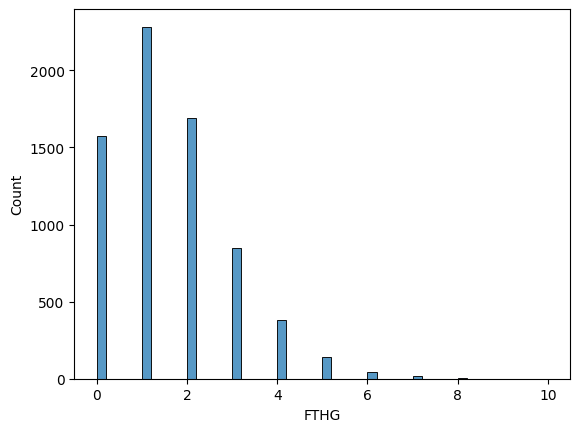

In [9]:
# Histogram of full time home goals distribution.

sns.histplot(data=df, x='FTHG', binwidth=0.2) 

<AxesSubplot: xlabel='FTAG', ylabel='Count'>

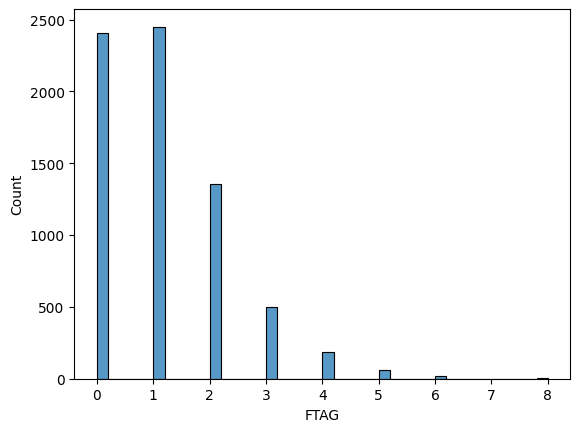

In [10]:
# Histogram of full time away goals distribution.

sns.histplot(data=df, x='FTAG', binwidth=0.2) 

<AxesSubplot: xlabel='FTHG', ylabel='FTAG'>

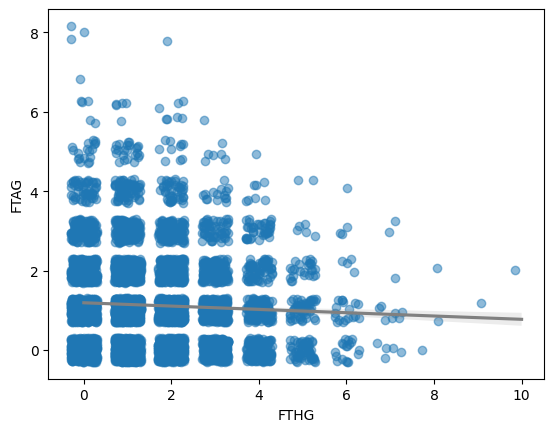

In [11]:
# Correlation between home and away goals.

sns.regplot(
    x='FTHG', 
    y='FTAG', 
    data=df, 
    order=1, 
    scatter_kws=dict(alpha=0.5), 
    line_kws=dict(color='gray'),
    x_jitter=0.3,
    y_jitter=0.3,
)

# Are the odds of different bookmakers similar?

In [12]:
# Checking when the three bookmakers give us the same prediction and when one of them (Bet365) is true.

df['is_bookmaker_R_equal'] = ((df['B365R']==df['IWR']) & (df['B365R']==df['WHR']))
df['is_B365_R_true'] = (df['B365R']==df['FTR'])
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,B365R,IWH,IWD,IWA,IWR,WHH,WHD,WHA,WHR,is_bookmaker_R_equal,is_B365_R_true
0,2002-08-31,Santander,Valladolid,0,1,A,1.909,3.25,3.400,H,2.10,3.0,3.1,H,2.00,3.1,3.3,H,True,False
1,2002-09-01,Barcelona,Ath Madrid,2,2,D,1.500,3.40,6.000,H,1.55,3.5,4.8,H,1.53,3.4,5.5,H,True,False
2,2002-09-01,La Coruna,Betis,2,4,A,1.500,3.40,6.000,H,1.50,3.7,5.0,H,1.53,3.4,5.5,H,True,False
5,2002-09-01,Sevilla,Celta,0,1,A,2.375,3.10,2.625,H,2.40,3.0,2.6,H,2.25,3.1,2.8,H,True,False
6,2002-09-01,Sociedad,Ath Bilbao,4,2,H,2.200,3.00,3.000,H,2.10,3.0,3.1,H,2.25,3.1,2.8,H,True,True


In [13]:
# On average, their categorical predictions are almost the same always. The accuracy is around 54 %.

df[['is_bookmaker_R_equal', 'is_B365_R_true']].mean()

is_bookmaker_R_equal    0.991985
is_B365_R_true          0.541577
dtype: float64

In [14]:
# Correlation between bookmaker odds.

for result in ['H', 'D', 'A']:
    print(df[['IW'+result, 'WH'+result, 'B365'+result]].corr())

            IWH       WHH     B365H
IWH    1.000000  0.979254  0.979067
WHH    0.979254  1.000000  0.988512
B365H  0.979067  0.988512  1.000000
            IWD       WHD     B365D
IWD    1.000000  0.957810  0.959007
WHD    0.957810  1.000000  0.970319
B365D  0.959007  0.970319  1.000000
            IWA       WHA     B365A
IWA    1.000000  0.959140  0.963513
WHA    0.959140  1.000000  0.971238
B365A  0.963513  0.971238  1.000000


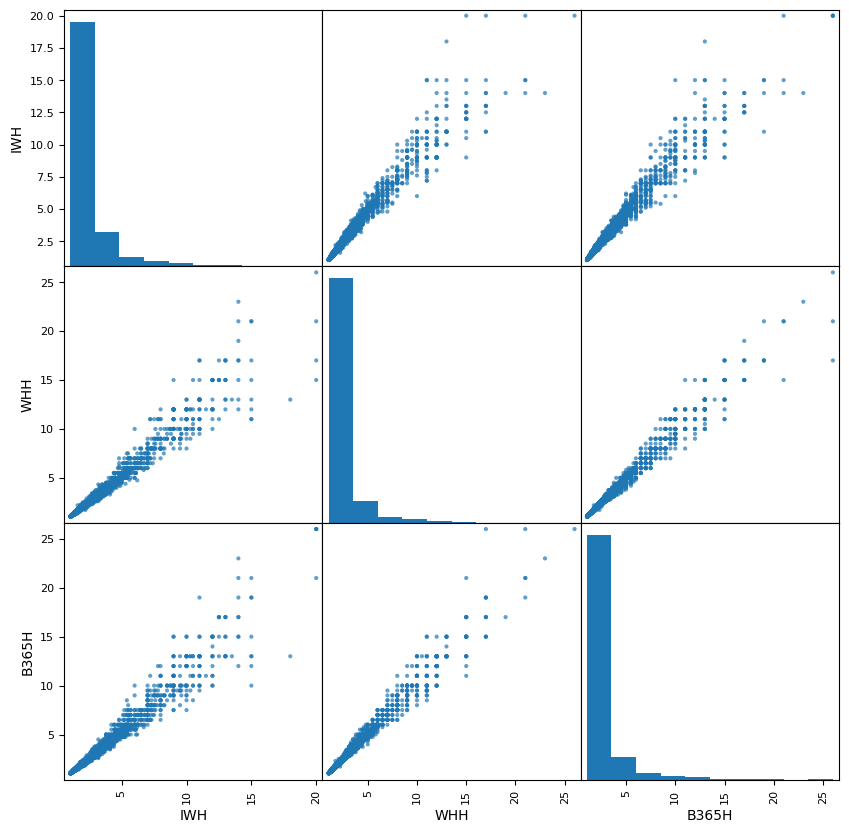

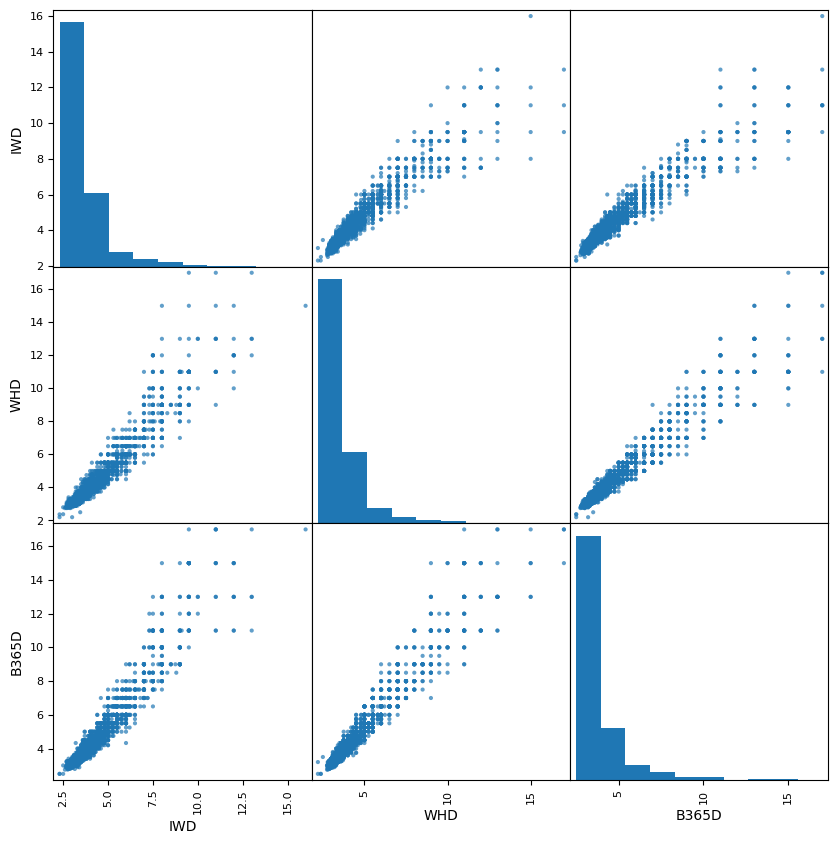

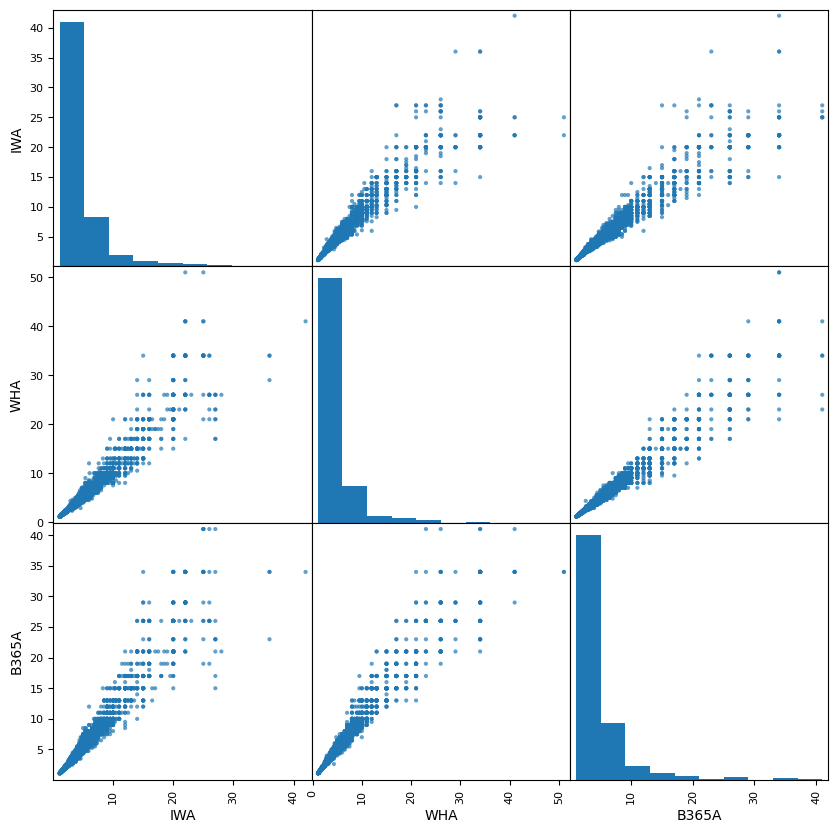

In [15]:
# Correlation plot between different bookmaker odds for each result.

for result in ['H', 'D', 'A']:
    pd.plotting.scatter_matrix(df[['IW'+result, 'WH'+result, 'B365'+result]], alpha=.7, figsize=(10,10))

# Accuracy of the bookmaker prediction

In [16]:
# Average accuracy.

df['is_B365_R_true'].mean()

0.5415772148275368

Text(0.5, 23.52222222222222, 'Predicted label')

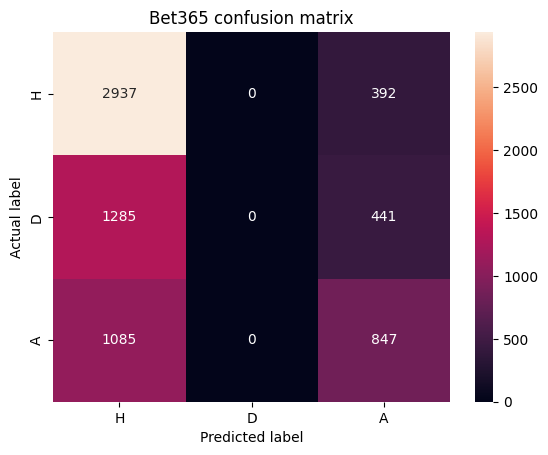

In [17]:
# Confusion matrix.

bookmaker_confusion_matrix = confusion_matrix(y_true=df['FTR'], y_pred=df['B365R'], labels=['H', 'D', 'A'])
bookmaker_confusion_matrix = pd.DataFrame(data=bookmaker_confusion_matrix, columns=['H', 'D', 'A'], index=['H', 'D', 'A'])

sns.heatmap(bookmaker_confusion_matrix, annot=True, fmt="d",)
plt.title('Bet365 confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Accuracy over time

In [18]:
# A season has around 380 matches -> rolling average of two seasons.

df['is_B365_R_true_average'] = df['is_B365_R_true'].rolling(380*2).mean()

(12437.1, 19452.9, 0.0, 1.0)

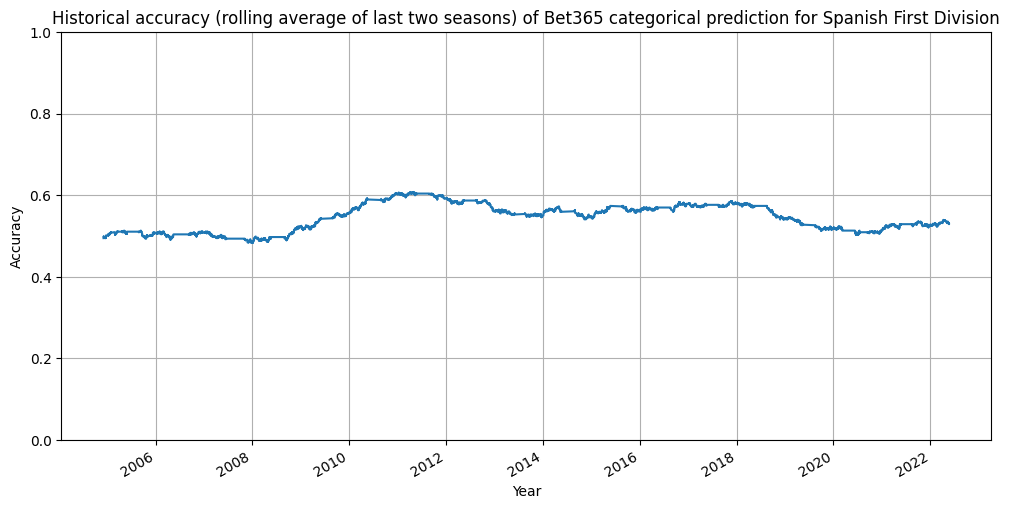

In [19]:
# Accuracy historical plot.

df.set_index('Date')['is_B365_R_true_average'].plot(
    figsize=(12,6), 
    title='Historical accuracy (rolling average of last two seasons) of Bet365 categorical prediction for Spanish First Division', 
    xlabel ="Year", 
    ylabel="Accuracy", 
    grid=True,
).axis([None, None, 0, 1])